Visualization of the residual stresses in the channel as predicted by MCT.

In [65]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.cm as cm
import matplotlib.colors as mc
import numpy as np
import scipy

In [14]:
import vtuIO
import meshio

Velocity profiles at different times:

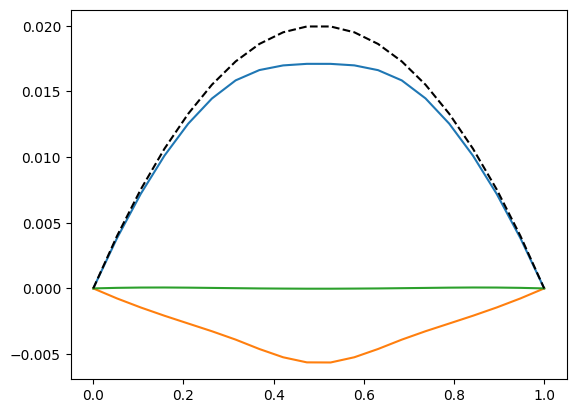

In [113]:
for t in [12,14,20]:
    file = vtuIO.VTUIO('mcttest/velocity0000{}.vtu'.format(t))
    y = np.linspace(0,1,20)
    vel = file.get_set_data('velocity',[(2.5,i,0) for i in y])
    plt.plot(y,vel[:,0])
plt.plot(y,0.02*(1-((y-0.5)/0.5)**2),color='black',linestyle='dashed')
plt.show()

Pressure gradient along the channel at different time points:

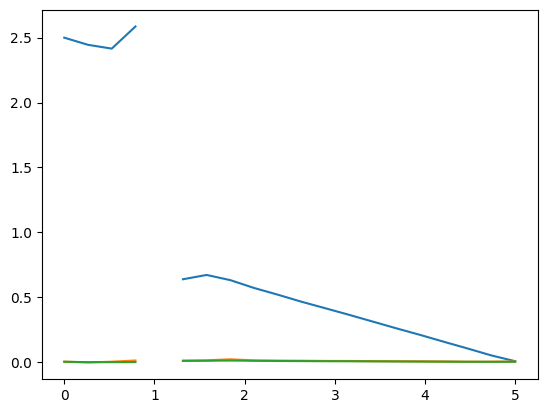

In [102]:
for t in [12,14,20]:
    file = vtuIO.VTUIO('mcttest/pressure0000{}.vtu'.format(t))
    x = np.linspace(0,5,20)
    p = file.get_set_data('pressure',[(i,0.5,0) for i in x])
    p[(x>0.8)&(x<1.2)] = np.nan
    plt.plot(x,p)
plt.show()

Velocity as a function of time at one point in the channel:

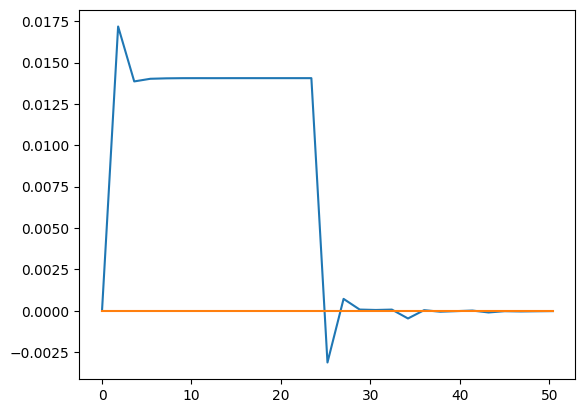

In [103]:
pvdfile = vtuIO.PVDIO('mcttest/velocity.pvd')
t = pvdfile.timesteps
vel = pvdfile.read_time_series('velocity', {'pt0': (2.0, 0.25, 0.0)})
plt.plot(t,vel['pt0'][:,0])
plt.plot(t,np.zeros_like(t))
plt.show()

The shear stress as a function of time does not decay to zero, even long after the velocity has vanished:

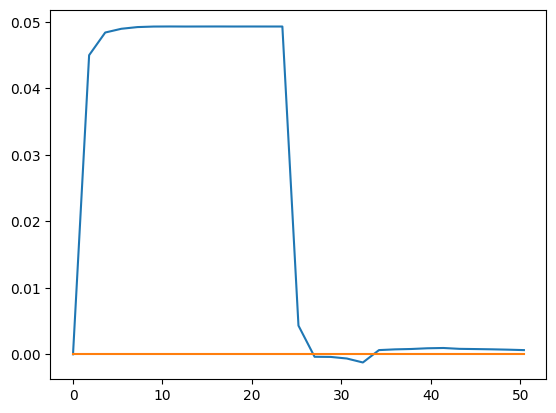

In [13]:
pvdfile = vtuIO.PVDIO('mcttest/stress.pvd')
t = pvdfile.timesteps
vel = pvdfile.read_time_series('total stress', {'pt0': (2.0, 0.25, 0.0)})
plt.plot(t,vel['pt0'][:,1])
plt.plot(t,np.zeros_like(t))
plt.show()

Visualization of the shear stress field long after switch off:

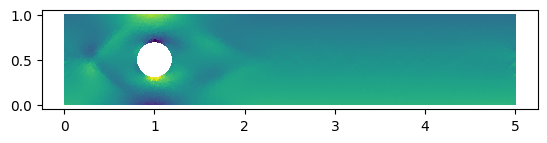

In [105]:
mio = meshio.read('mcttest/stress000028.vtu')
pts = np.array(mio.points)
X,Y,Z = pts[:,0],pts[:,1],pts[:,2]
tri = np.array(mio.cells[0].data)
triangulation = mtri.Triangulation(X,Y,triangles=tri)
sigma = np.array(mio.get_cell_data('total stress','triangle'))
values = sigma[:,1]
plt.tripcolor(triangulation, values)
plt.gca().set_aspect(1)
plt.show()

Colormap according to Sørensen:

In [81]:
def sorensen_colormap(normalized=False):
    cietab = np.genfromtxt('http://www.cvrl.org/database/data/cmfs/ciexyz31.csv',delimiter=',')
    MRGB = np.array([[  2.04414, -0.5649, -0.3447 ],
                     [ -0.9693,   1.8760,  0.0416 ],
                     [  0.0134,  -0.1184,  1.0154 ]])
    def L(Gamma, lam):
        gg, ll = np.meshgrid(Gamma,lam)
        return np.transpose(np.sin(np.pi/ll*gg))**2
    lam = cietab[:,0]
    Gamma = np.linspace(0,1000.,500)
    X = scipy.integrate.trapezoid(L(Gamma,lam)*cietab[:,1],cietab[:,0],axis=1)
    Y = scipy.integrate.trapezoid(L(Gamma,lam)*cietab[:,2],cietab[:,0],axis=1)
    Z = scipy.integrate.trapezoid(L(Gamma,lam)*cietab[:,3],cietab[:,0],axis=1)
    if normalized:
        norm = np.max(Gamma)
    else:
        norm = 1
    RGB = np.clip(np.dot(MRGB,[X,Y,Z])/100., 0, 1)**0.5
    return dict(zip(('cmap','norm'),mc.from_levels_and_colors(Gamma/norm,RGB.T[:-1])))

Stress-birefringence plot of residual stresses:

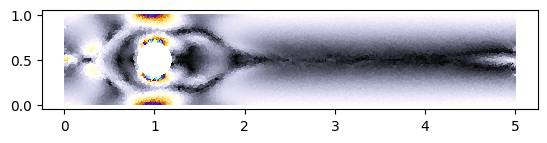

In [82]:
mio = meshio.read('mcttest/stress000028.vtu')
pts = np.array(mio.points)
X,Y,Z = pts[:,0],pts[:,1],pts[:,2]
tri = np.array(mio.cells[0].data)
triangulation = mtri.Triangulation(X,Y,triangles=tri)
sigma = np.array(mio.get_cell_data('total stress','triangle'))
values = 200*np.sqrt((sigma[:,0]-sigma[:,4])**2/4+sigma[:,1]**2)
plt.tripcolor(triangulation, values,**sorensen_colormap(normalized=True))
plt.gca().set_aspect(1)
plt.show()